In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load the data
file_path = '/Users/matthewmoore/Downloads/training.1600000.processed.noemoticon.csv'
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv(file_path, encoding='ISO-8859-1', names=columns)

# Display first rows
print(df.head())
print(f"Dataset shape: {df.shape}")

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
Dataset shape: (1600000, 6)


In [2]:
# Select only target and text columns
df = df[['target', 'text']]

# Convert target labels: 0 -> 0, 2 -> 1, 4 -> 2
df['target'] = df['target'].replace({0: 0, 2: 1, 4: 2})

# Clean the text: remove links, special characters, etc.
import re
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # Remove non-alphanumeric characters
    return text

df['text'] = df['text'].apply(clean_text)

# Split the data
X = df['text'].values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")

Training data size: 1280000
Test data size: 320000


In [3]:
# Tokenization parameters
vocab_size = 10000  # Vocabulary size
max_length = 50     # Maximum length of sequences
embedding_dim = 128  # Embedding dimensions

# Tokenize the text
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')

print(f"Example of padded sequence: {X_train_seq[0]}")

Example of padded sequence: [   1   53  115   44    2   37 1315   19  365   11 4082    7   13   27
  154  559  219   50   94    5 1942    1    3   20  193  511  233 1170
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [4]:
# Model 1: GRU-based model
model_gru = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GRU(128, return_sequences=False),
    Dense(3, activation='softmax')  # 3 classes: negative, neutral, positive
])

model_gru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1379459 (5.26 MB)
Trainable params: 1379459 (5.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# Model 2: LSTM-based model
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),
    Dense(3, activation='softmax')  # 3 classes
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1411971 (5.39 MB)
Trainable params: 1411971 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# Model 3: GRU + LSTM (Bidirectional)
model_gru_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(3, activation='softmax')  # 3 classes
])

model_gru_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_gru_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 50, 128)           74496     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1453699 (5.55 MB)
Trainable params: 1453699 (5.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Define training parameters
epochs = 5
batch_size = 128

# Train GRU model
history_gru = model_gru.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=epochs, batch_size=batch_size)

# Train LSTM model
history_lstm = model_lstm.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=epochs, batch_size=batch_size)

# Train GRU + LSTM model
history_gru_lstm = model_gru_lstm.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/5
10000/10000 [==============================] - 1125s 112ms/step - loss: 0.4153 - accuracy: 0.8073 - val_loss: 0.3883 - val_accuracy: 0.8239
Epoch 2/5
10000/10000 [==============================] - 1384s 138ms/step - loss: 0.3732 - accuracy: 0.8318 - val_loss: 0.3776 - val_accuracy: 0.8298
Epoch 3/5
10000/10000 [==============================] - 1360s 136ms/step - loss: 0.3524 - accuracy: 0.8432 - val_loss: 0.3733 - val_accuracy: 0.8325
Epoch 4/5
10000/10000 [==============================] - 1405s 140ms/step - loss: 0.3340 - accuracy: 0.8531 - val_loss: 0.3777 - val_accuracy: 0.8318
Epoch 5/5
10000/10000 [==============================] - 1869s 187ms/step - loss: 0.3148 - accuracy: 0.8632 - val_loss: 0.3834 - val_accuracy: 0.8300
Epoch 1/5
10000/10000 [==============================] - 1821s 181ms/step - loss: 0.4391 - accuracy: 0.7818 - val_loss: 0.3906 - val_accuracy: 0.8225
Epoch 2/5
10000/10000 [==============================] - 1587s 159ms/step - loss: 0.3747 - accuracy:

In [8]:
# Evaluate each model
print("Evaluating GRU Model")
gru_results = model_gru.evaluate(X_test_seq, y_test)
print(f"Test Accuracy: {gru_results[1]:.4f}")

print("Evaluating LSTM Model")
lstm_results = model_lstm.evaluate(X_test_seq, y_test)
print(f"Test Accuracy: {lstm_results[1]:.4f}")

print("Evaluating GRU + LSTM Model")
gru_lstm_results = model_gru_lstm.evaluate(X_test_seq, y_test)
print(f"Test Accuracy: {gru_lstm_results[1]:.4f}")

Evaluating GRU Model
10000/10000 [==============================] - 170s 17ms/step - loss: 0.3834 - accuracy: 0.8300
Test Accuracy: 0.8300
Evaluating LSTM Model
10000/10000 [==============================] - 247s 25ms/step - loss: 0.3864 - accuracy: 0.8301
Test Accuracy: 0.8301
Evaluating GRU + LSTM Model
10000/10000 [==============================] - 211s 21ms/step - loss: 0.3861 - accuracy: 0.8288
Test Accuracy: 0.8288


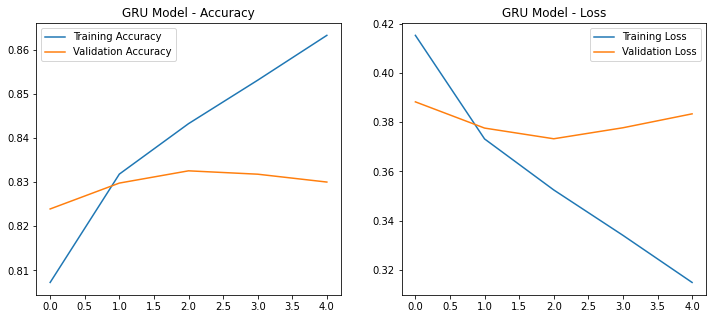

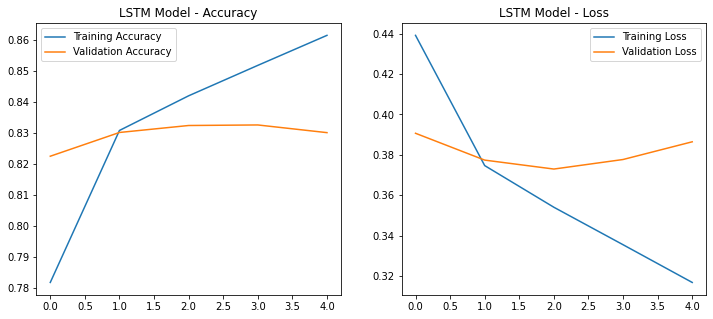

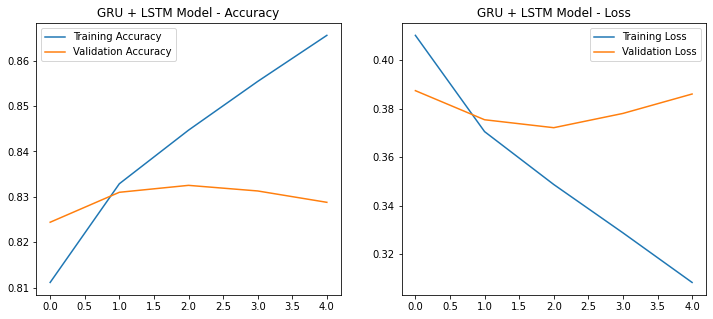

In [9]:
def plot_performance(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.show()

# Plot performance
plot_performance(history_gru, "GRU Model")
plot_performance(history_lstm, "LSTM Model")
plot_performance(history_gru_lstm, "GRU + LSTM Model")

10000/10000 [==============================] - 137s 14ms/step
Classification Report for GRU Model:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83    160000
           2       0.83      0.82      0.83    160000

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



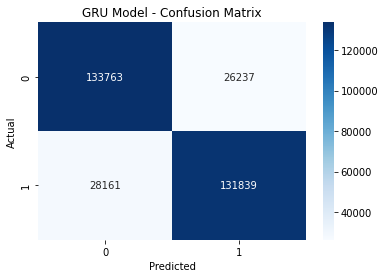

10000/10000 [==============================] - 239s 24ms/step
Classification Report for LSTM Model:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83    160000
           2       0.82      0.85      0.83    160000

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



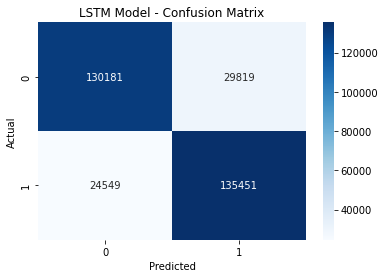

10000/10000 [==============================] - 207s 20ms/step
Classification Report for GRU + LSTM Model:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    160000
           2       0.83      0.82      0.83    160000

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



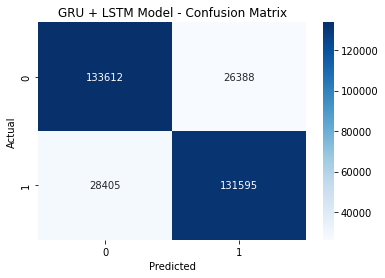

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# Evaluate all models
evaluate_model(model_gru, X_test_seq, y_test, "GRU Model")
evaluate_model(model_lstm, X_test_seq, y_test, "LSTM Model")
evaluate_model(model_gru_lstm, X_test_seq, y_test, "GRU + LSTM Model")

The evaluation of each model reveals that they all perform realtively similar, right at the 83% mark. As a result, I think either model would be fine to select in this process. But, I think I would choose